In [1]:

import pandas as pd
import logging
import numpy as np
import sys
import matplotlib.pyplot as plt
import time
import operator
import os
from sklearn.cross_validation import train_test_split
from random import shuffle
from sklearn.base import BaseEstimator, RegressorMixin
from scipy.optimize import minimize
from sklearn.model_selection import GridSearchCV, PredefinedSplit
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.model_selection import StratifiedKFold

%matplotlib inline

#PLOT CONFUSION MATRIX
from sklearn.metrics import confusion_matrix
import itertools
import pickle
#matrix inverse
from numpy.linalg import inv
import jj_basic_fn as JJ
from hyperparams import Hyperparams as hp
from patient import patient
import prep
import plot_funcs
import modules
#default size of the graph
plt.rcParams['figure.figsize'] = (10.0, 8.0) 

%load_ext autoreload
%autoreload 2

pd.set_option('display.max_rows', 20)
pd.set_option('display.max_columns', 20)
pd.set_option('display.max_colwidth', -1)

n_classifier = 7

/Users/hp/anaconda/envs/python3/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
p231, p222_1, p222_2, p222_3 = modules.build_patients()
pat_list = [p231, p222_1, p222_2, p222_3]
for pat in pat_list:
    JJ.save_object(pat, '../patients/' + pat.id +'.p')

/Users/hp/anaconda/envs/python3/lib/python3.5/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/Users/hp/anaconda/envs/python3/lib/python3.5/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)


In [3]:
col_rs = hp.col_rs
col_es = hp.col_es
col_le = hp.col_le

p231, p222_1, p222_2, p222_3 = pickle.load(open(hp.prepath_pat + "231.p", "rb" )),pickle.load(open(hp.prepath_pat + "222_1.p", "rb" )), pickle.load(open(hp.prepath_pat + "222_2.p", "rb" )), pickle.load(open(hp.prepath_pat + "222_3.p", "rb" ))


In [13]:
def parameter_tuning(pat, X_train, X_test, y_train, y_test, classifier, C_range_num = 30, if_save = 0,
                     nfold = 10, if_show = 1):
    #defs is a dictionary to initiate classifier with the parameters that don't need to be tuned
    defs = {}
    defs['classifier'] = classifier
    
    num_instances, num_features = X_train.shape[0], X_train.shape[1]
    n_fold = 10

    skf = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=42)
    CV = skf.split(np.zeros(len(y_train)), y_train)
    

    if classifier==1:
        clf_name = 'Logistic Regression'
        defs['class_weight'] = 'balanced'
        defs['max_iter'] = 200
        C_range = 10 ** np.random.uniform(-2, 1, size = C_range_num)
        tuned_params = dict(penalty=['l1','l2'], C=C_range)
    elif classifier == 2: 
        clf_name = 'SVM'
        defs['class_weight'] = 'balanced'
        kernel_list = ['rbf']    
        gamma_list = [2**i*1/num_features for i in range(1)]
        #degree_list = [2,3,4,5]
        C_range = 10 ** np.random.uniform(-3, 1, size = C_range_num)
        tuned_params = dict(kernel=kernel_list,gamma = gamma_list, C=C_range)

    elif classifier==3:
        clf_name = 'Gaussian Naive Bayes classifier'
        prr = np.ones(2) * (1.0/2)
        defs['priors'] = prr
        clf_try = JJ.clf_list(defs)
        clf_try.fit(X_train, y_train)
        pat.estimator[classifier] = clf_try
        return

    elif classifier==4:
        clf_name = 'Linear Discriminant Analysis'
        prr = np.ones(2) * (1.0/2)
        defs['solver'] = 'eigen'  # 'svd', 'lsqr', 'eigen'
        defs['shrinkage'] = 'auto'
        defs['priors'] = prr
        clf_try = JJ.clf_list(defs)
        clf_try.fit(X_train, y_train)
        pat.estimator[classifier] = clf_try
        return
    elif classifier == 5:
        clf_name = 'decision tree'
        mss_list = [5,10,20,40,60]
        criterion_list = ['entropy']
        max_depth_list = [3,4,5,8,12,18]
        clf_name = 'decision tree'
        tuned_params = dict(criterion=criterion_list, min_samples_split=mss_list, max_depth = max_depth_list)
    elif classifier == 6:
        clf_name = 'random forest'
        defs['n_estimators'] = 600
        mss_list = [20,25,30,40]
        criterion_list = ['entropy']
        max_depth_list = [12,13,14,15,16]
        max_features_list = ['auto']
        tuned_params = dict(criterion=criterion_list, min_samples_split=mss_list, max_depth = max_depth_list, max_features = max_features_list)
    elif classifier == 7:
        clf_name = 'gradient boosting'
        defs['n_estimators'] = 2000
        max_depth_list, subsample_list, learning_rate_list, min_samples_leaf_list = [1,2,3], [0.1,0.15,0.2, 0.3, 0.4], [0.02, 0.01,0.005], [10,20,30] 
        #params = {'n_estimators': 1200, 'max_depth': 3, 'subsample': 0.5,
        #  'learning_rate': 0.01, 'min_samples_leaf': 10, 'random_state': 3}
        tuned_params = dict(max_depth=max_depth_list, subsample = subsample_list,learning_rate = learning_rate_list, min_samples_leaf= min_samples_leaf_list)
    
        
    clf_try = JJ.clf_list(defs)
    
    clf_grid = GridSearchCV(clf_try,
                            param_grid=tuned_params,
                            cv=CV,
                            scoring = 'roc_auc',
                            verbose=1,
                           return_train_score = True)
    clf_grid.fit(X_train, y_train)
    print('Best score for validations set: {}'.format(clf_grid.best_score_))
    print('Best parameters: {}'.format(clf_grid.best_params_))

    clf_best = clf_grid.best_estimator_

    y_pred = clf_best.predict(X_test)
    df = pd.DataFrame(clf_grid.cv_results_)
    if if_show:
        JJ.show_result(y_pred, y_test, df, clf_name, if_save = if_save)
    
    if if_save:
        pat.result[classifier] = df
        pat.estimator[classifier] = clf_best
        pat.score[classifier] = clf_grid.best_score_
        pat.params[classifier] = clf_grid.best_params_



Total outliers removed: 4
Fitting 10 folds for each of 100 candidates, totalling 1000 fits
Best score: 0.5198745265151515
Best parameters: {'C': 3.367425696452662, 'gamma': 0.03571428571428571, 'kernel': 'rbf'}
Confusion matrix, without normalization


[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    7.6s finished


,params,mean_test_score
17,"{'C': 3.367425696452662, 'gamma': 0.03571428571428571, 'kernel': 'rbf'}",0.519875
95,"{'C': 4.066303932703508, 'gamma': 0.03571428571428571, 'kernel': 'rbf'}",0.519059
8,"{'C': 2.9538104231669244, 'gamma': 0.03571428571428571, 'kernel': 'rbf'}",0.518047
50,"{'C': 5.1078056353343335, 'gamma': 0.03571428571428571, 'kernel': 'rbf'}",0.515139
77,"{'C': 9.456107898731728, 'gamma': 0.03571428571428571, 'kernel': 'rbf'}",0.511334
98,"{'C': 9.625156258767415, 'gamma': 0.03571428571428571, 'kernel': 'rbf'}",0.511323
78,"{'C': 9.819711848524475, 'gamma': 0.03571428571428571, 'kernel': 'rbf'}",0.510084
24,"{'C': 6.538221379424559, 'gamma': 0.03571428571428571, 'kernel': 'rbf'}",0.509576
52,"{'C': 2.1047163975074117, 'gamma': 0.03571428571428571, 'kernel': 'rbf'}",0.509472
93,"{'C': 7.15167967617213, 'gamma': 0.03571428571428571, 'kernel': 'rbf'}",0.508297


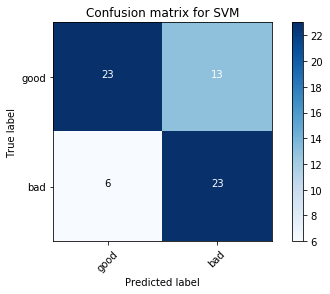

In [14]:
X_train, X_test, y_train, y_test = modules.get_ml_data(p222_3)
parameter_tuning(p222_3,X_train, X_test, y_train, y_test, 2, C_range_num = 100, 
                     nfold = 10, if_save = 1, if_show = 1)

In [15]:
def parameter_tuning_all(pat, C_range_num, if_scaler = 1, if_remove_icd = 1, if_save = 1, if_show = 0):
    X_train, X_test, y_train, y_test = modules.get_ml_data(pat, if_scaler = if_scaler, if_remove_icd = if_remove_icd)
    for classifier_int in range(1,hp.num_classifier + 1):
        parameter_tuning(pat, X_train, X_test, y_train, y_test, C_range_num = C_range_num, classifier = classifier_int, if_save = if_save, if_show = if_show)
    JJ.save_object(pat, '../patients/' + pat.id +'_trained.p')

In [16]:
parameter_tuning_all(p231, C_range_num = 100, if_scaler = 1, if_remove_icd = 1, if_save = 1)

Total outliers removed: 30
Fitting 10 folds for each of 200 candidates, totalling 2000 fits


[Parallel(n_jobs=1)]: Done 2000 out of 2000 | elapsed:   12.4s finished


Best score: 0.8430165478397513
Best parameters: {'C': 0.206784038727329, 'penalty': 'l1'}
Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:   27.0s finished


Best score: 0.8577995965155816
Best parameters: {'C': 3.160617682359838, 'gamma': 0.03571428571428571, 'kernel': 'rbf'}
Fitting 10 folds for each of 30 candidates, totalling 300 fits


[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    3.3s finished


Best score: 0.8099225229541345
Best parameters: {'max_depth': 3, 'criterion': 'entropy', 'min_samples_split': 5}
Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:  4.5min finished


Best score: 0.8565698631284422
Best parameters: {'max_depth': 14, 'criterion': 'entropy', 'min_samples_split': 20, 'max_features': 'auto'}
Fitting 10 folds for each of 135 candidates, totalling 1350 fits


[Parallel(n_jobs=1)]: Done 1350 out of 1350 | elapsed: 26.0min finished


Best score: 0.8666731998164295
Best parameters: {'min_samples_leaf': 20, 'subsample': 0.2, 'max_depth': 1, 'learning_rate': 0.005}


In [39]:

X_train, X_test, y_train, y_test = JJ.get_ml_data(data, '231', if_scaler = 1, if_remove_icd = 1)
#parameter_tuning(X_train, X_test, y_train, y_test, classifier = 1, C_range_num = 100, if_save = 1)
JJ.ensemble_model(X_train, y_train, X_test, y_test, patid = '231', if_save = 0)

0.825


In [97]:
1

1